In [7]:
%matplotlib inline
import qiskit
from qiskit import IBMQ
from qiskit import Aer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QiskitError
from qiskit.quantum_info.operators import Operator
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city
from qiskit.providers.aer import noise
import random
from math import *
import math
import matplotlib
import numpy as np
%config InlineBackend.figure_format = 'png' # Makes the images look nice

In [2]:
backend = Aer.get_backend('statevector_simulator')

In [3]:
def apply_oracle(circuit, n_string, index_position, match_position, pattern_position, ancilla_position):
    temp_position = n_string
    n_pattern = pattern_position - match_position
    n_index = ancilla_position - index_position
    # apply oracle


    delta = 1
    
    for i in range(n_index):
        n_reg = n_string if i < n_index - 1 else n_pattern
        for j in range(n_reg):
            # not shifted
            circuit.x(index_position + i)
#             print(temp_position - n_string + j, index_position + i, temp_position + j)
            circuit.ccx(temp_position - n_string + j, index_position + i, temp_position + j)
            circuit.x(index_position + i)
            # shifted
            if j + delta < n_string:
                circuit.ccx(temp_position - n_string + j + delta, index_position + i, temp_position + j)
        delta *= 2
        temp_position += n_string
        circuit.barrier()
    
    
    
    for i in range(n_pattern):
        # 111
        circuit.ccx(match_position + i, pattern_position + i, ancilla_position + i)
        
        # 001
        circuit.x(match_position + i)
        circuit.x(pattern_position + i)
        circuit.ccx(match_position + i, pattern_position + i, ancilla_position + i)
        circuit.x(match_position + i)
        circuit.x(pattern_position + i)
        
        circuit.barrier()
        
    
#     circuit.h(ancilla_position + n_pattern)
    circuit.mct(list(range(ancilla_position, ancilla_position + n_pattern)), ancilla_position + n_pattern)
#     circuit.h(ancilla_position + n_pattern)
    
    circuit.barrier()
    
    # reverse oracle
    for i in range(n_pattern - 1, -1, -1):
        # 001
        circuit.x(pattern_position + i)
        circuit.x(match_position + i)
        circuit.ccx(match_position + i, pattern_position + i, ancilla_position + i)
        circuit.x(pattern_position + i)
        circuit.x(match_position + i)
        
        # 111
        circuit.ccx(match_position + i, pattern_position + i, ancilla_position + i)
        circuit.barrier()
        

    delta = 1
    temp_position = n_string
    
    for i in range(n_index):
        n_reg = n_string if i < n_index - 1 else n_pattern
        for j in range(n_reg):
            # not shifted
            circuit.x(index_position + i)
#             print(temp_position - n_string + j, index_position + i, temp_position + j)
            circuit.ccx(temp_position - n_string + j, index_position + i, temp_position + j)
            circuit.x(index_position + i)
            # shifted
            if j + delta < n_string:
                circuit.ccx(temp_position - n_string + j + delta, index_position + i, temp_position + j)
            
        delta *= 2
        temp_position += n_string
        circuit.barrier()

    
    # diffusion
    for i in range(n_index):
        circuit.h(index_position + i)
        circuit.x(index_position + i)
        
    circuit.mct(list(range(index_position, index_position + n_index)), ancilla_position + n_pattern)
    
    for i in range(n_index):
        circuit.x(index_position + i)
        circuit.h(index_position + i)
        
    circuit.barrier()
    
    return circuit
        

In [4]:
def make_pattern_matching_circuit(string, pattern):    
    n_string = len(string)
    n_pattern = len(pattern)
    
    if n_pattern > n_string:
        raise Error('pattern should be shorter than string.')
    
    # T = n_string - n_pattern + 1, T = 1 => 1, T = 2 => 2, T = 4 => 3 
    n_index = math.ceil(np.log2(n_string - n_pattern + 1))
    
    n_qubits = n_string * n_index + n_pattern * 3 + n_index + 1
    
    string_reg = QuantumRegister(n_string, 'reg_string')
    temp_regs = [QuantumRegister(n_string, 'reg_temp_' + str(i)) for i in range(n_index - 1)]
    match_reg = QuantumRegister(n_pattern, 'reg_match')
    pattern_reg = QuantumRegister(n_pattern, 'reg_pattern')
    index_reg = QuantumRegister(n_index, 'reg_index')
    ancilla_reg = QuantumRegister(n_pattern + 1, 'reg_ancilla')
    
    registers = [string_reg, *temp_regs, match_reg, pattern_reg, index_reg, ancilla_reg]
    
    qc = QuantumCircuit(*registers)
    
    # set positions for later use
    temp_position = n_string
    match_position = n_string * n_index
    pattern_position = match_position + n_pattern
    index_position = pattern_position + n_pattern
    ancilla_position = index_position + n_index
    
    # initialize inputs
    for i in range(n_string):
        qc.initialize([1, 0] if string[-1-i] == 0 else [0, 1], i)
    for i in range(n_pattern):
        qc.initialize([1, 0] if pattern[-1-i] == 0 else [0, 1], n_string * n_index + n_pattern + i)

    # initialize index
    for i in range(n_index):
        qc.h(n_string * n_index + n_pattern * 2 + i)
#         qc.initialize([1, 0], n_string * n_index + n_pattern * 2 + i)
        
    qc.x(ancilla_position + n_pattern)
    qc.h(ancilla_position + n_pattern)
    
    qc.barrier()
        
    # oracle
    for i in range(2):
        qc = apply_oracle(qc, n_string, index_position, match_position, pattern_position, ancilla_position)
        
    return qc
    

In [5]:
STRING = [1, 0, 1, 1, 0]
PATTERN = [1, 1]

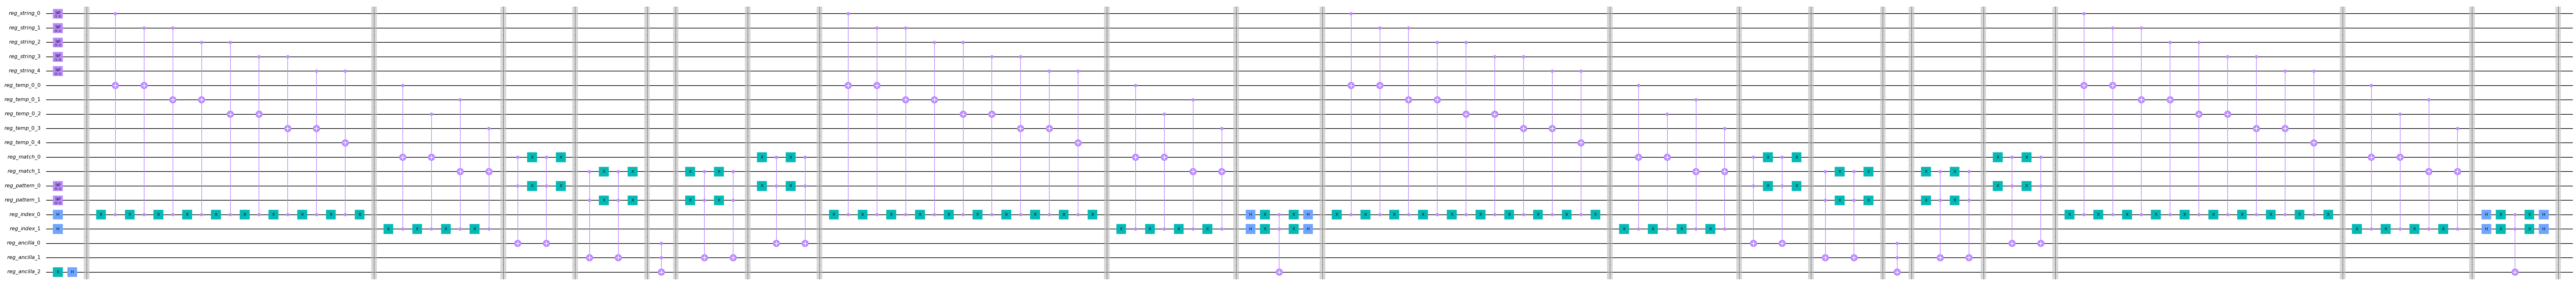

In [8]:
qc = make_pattern_matching_circuit(STRING, PATTERN)


circuit_drawer(qc, output='mpl', fold=-1)
# qc.draw(fold=-1)

In [98]:
result = execute(qc, backend).result()
counts = result.get_counts()

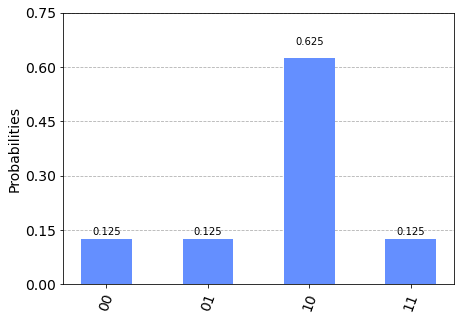

In [80]:
def partial_counts(counts):
    n_string = len(STRING)
    n_pattern = len(PATTERN)
    n_index = math.ceil(np.log2(n_string - n_pattern + 1))
    match_position = n_string * n_index
    pattern_position = match_position + n_pattern
    index_position = pattern_position + n_pattern
    
    nc = {}
    for k, v in counts.items():
        rk = k[::-1][index_position:index_position+n_index]
        if rk not in nc: nc[rk] = 0.0
        nc[rk] += v
    return nc
        
# plot_histogram(counts)
plot_histogram(partial_counts(counts))

In [598]:
def format_state(state_string, n_string, n_pattern, n_index, value):
    temp_position = n_string
    match_position = n_string * n_index
    pattern_position = match_position + n_pattern
    index_position = pattern_position + n_pattern
    ancilla_position = index_position + n_index
    
    rev_state = state_string[::-1]
    print('string', rev_state[:n_string])
    print('match', rev_state[match_position:match_position+n_pattern])
    print('pattern', rev_state[pattern_position:pattern_position+n_pattern])
    print('index', rev_state[index_position:index_position+n_index])
    print('probability', value)
    print('==============')

for k, v in counts.items():
    format_state(k, len(STRING), len(PATTERN), 2, v)
    

string 100101
match 000
pattern 101
index 00
probability 0.0703125
string 100101
match 100
pattern 101
index 00
probability 0.03125
string 100101
match 110
pattern 101
index 00
probability 0.0078125
string 100101
match 101
pattern 101
index 00
probability 0.03125
string 100101
match 011
pattern 101
index 00
probability 0.0078125
string 100101
match 111
pattern 101
index 00
probability 0.0078125
string 100101
match 000
pattern 101
index 10
probability 0.0703125
string 100101
match 110
pattern 101
index 10
probability 0.0078125
string 100101
match 001
pattern 101
index 10
probability 0.03125
string 100101
match 101
pattern 101
index 10
probability 0.03125
string 100101
match 011
pattern 101
index 10
probability 0.0078125
string 100101
match 111
pattern 101
index 10
probability 0.0078125
string 100101
match 000
pattern 101
index 01
probability 0.0703125
string 100101
match 010
pattern 101
index 01
probability 0.03125
string 100101
match 110
pattern 101
index 01
probability 0.0078125
strin

In [580]:
H = 1/np.sqrt(2) * np.matrix([[1,1], [1,-1]])
X = np.matrix([[0, 1], [1, 0]])
I = np.matrix([[1, 0], [0, 1]])

In [477]:
CCCX = np.matrix([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
])
CX = np.matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

In [478]:
big = np.kron(np.kron(np.kron(H*X, H*X), H*X), I)

In [437]:
big_dagger = np.transpose(big)

In [441]:
big * CCCX * big_dagger

matrix([[ 0.875,  0.125, -0.125,  0.125, -0.125,  0.125, -0.125,  0.125,
         -0.125,  0.125, -0.125,  0.125, -0.125,  0.125, -0.125,  0.125],
        [ 0.125,  0.875,  0.125, -0.125,  0.125, -0.125,  0.125, -0.125,
          0.125, -0.125,  0.125, -0.125,  0.125, -0.125,  0.125, -0.125],
        [-0.125,  0.125,  0.875,  0.125, -0.125,  0.125, -0.125,  0.125,
         -0.125,  0.125, -0.125,  0.125, -0.125,  0.125, -0.125,  0.125],
        [ 0.125, -0.125,  0.125,  0.875,  0.125, -0.125,  0.125, -0.125,
          0.125, -0.125,  0.125, -0.125,  0.125, -0.125,  0.125, -0.125],
        [-0.125,  0.125, -0.125,  0.125,  0.875,  0.125, -0.125,  0.125,
         -0.125,  0.125, -0.125,  0.125, -0.125,  0.125, -0.125,  0.125],
        [ 0.125, -0.125,  0.125, -0.125,  0.125,  0.875,  0.125, -0.125,
          0.125, -0.125,  0.125, -0.125,  0.125, -0.125,  0.125, -0.125],
        [-0.125,  0.125, -0.125,  0.125, -0.125,  0.125,  0.875,  0.125,
         -0.125,  0.125, -0.125,  0.125, -0.1

In [443]:
small = np.kron(H*X, I)

In [444]:
small_dagger = np.transpose(small)

In [447]:
diff = small * CX * small_dagger

In [448]:
orc = [0.5, -0.5, -0.5, 0.5]


In [454]:
np.identity(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [466]:
H_2 = np.kron(H, H)

In [468]:
diff_op = H_2 * (np.matrix([[1, 0, 1, 0]]).T * np.matrix([[1, 0, 1, 0]]) * 2 - np.identity(4)) * H_2

In [469]:
orc * diff_op

matrix([[-0.5,  0.5,  0.5, -0.5]])

In [470]:
np.matrix([[1, 0, 1, 0]]).T * np.matrix([[1, 0, 1, 0]])

matrix([[1, 0, 1, 0],
        [0, 0, 0, 0],
        [1, 0, 1, 0],
        [0, 0, 0, 0]])

In [467]:
H_2


matrix([[ 0.5,  0.5,  0.5,  0.5],
        [ 0.5, -0.5,  0.5, -0.5],
        [ 0.5,  0.5, -0.5, -0.5],
        [ 0.5, -0.5, -0.5,  0.5]])